# Connectionist Sudoku
This is my attempt to use Paul Thagard's ECHO algorithm for solving Sudoku.
ECHO is a connectionist algorithm for finding the most coherent explanations for observations and our idea was to adopt this for the constraint satisfaction game. 

Source: https://www.cambridge.org/core/journals/behavioral-and-brain-sciences/article/explanatory-coherence/E05CB61CD64C26138E794BC601CC9D7A


### Nomenclature for Sudoku
Copied from Peter Norvig:
http://norvig.com/sudoku.html

Shown with a simple 4x4 Sudoku:

![alt-text](https://raw.githubusercontent.com/MaxRae/ConnectionistSudoku/master/Media/SudokuNomenclature.png)

### Sketch of the weight matrix
Example of a 4x4 Sudoku
![alt text](https://raw.githubusercontent.com/MaxRae/ConnectionistSudoku/master/Media/WeightMatrix.png)


In [0]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Setting up the units
One unit represents one proposition, for example "There is a 1 in the first square." The activation of a unit represents its plausibility.


The activation of units that are given (i.e. numbers that are already filled at the beginning) is clamped at 1.

In [0]:
class Unit:
    def __init__(self, activation, index):
        self.activation = activation
        self.index = index
        self.activation_history = [self.activation]
        
    def update(self, weights, activations,  threshold, decay=.1):
        """Simply the updating rule by Thagard (1989)"""
        i,j,k = self.index
        previous_activation = self.activation
        net = sum(sum(sum(weights[i,j,k] * activations)))
        if net > 0:
            self.activation = self.activation*(1-decay) + net*(1-self.activation)
        else: 
            self.activation = self.activation*(1-decay) + net*(self.activation + 1)
        self.activation = np.round(self.activation, decimals=2)
        self.activation_history.append(self.activation)
        
        difference = np.abs(previous_activation-self.activation)
        if difference > threshold:
            return True
        

            
class ClampedUnit(Unit):
    # So called evidence units whose activation is fixed at 1
    # In our case the sudoku numbers filled from the start
    def update(self, *args, **kwargs):
        self.activation_history.append(1)
            
          

In [0]:
def get_boxindeces(size):
    """Reused code for getting i,j indexes of the squares in the boxes in a 
    Sudoku. Don't ask me how this works, writing this caused some brain strain."""
    boxindeces = []
    blocklength = int(np.sqrt(size))
    for m in range(0, size, blocklength):
        for n in range(0, size, blocklength):
            box = []
            for k in range(0, blocklength):
                box.append((m+k,n))
                for l in range(1, blocklength):
                    box.append((m+k, n+l))
            boxindeces.append(box)
    return boxindeces

## Setting up ECHO
We need to specify the weights between all units, initiliaze all units and clamped units and then be able to update their activation according to the weights between the units.

In [0]:
class ECHO:
    def __init__(self, sudoku, threshold=.1):
        self.threshold = threshold
        # Sudoku is passed like this:
        # example4x4 = [[0., 1., 0., 0.], [0., 0., 0., 1.], ...]
        # = 2 in first and a 4 in second square
        self.size = len(sudoku[0]) # this should be 4, for the example
        
        # create a list of units, where one unit corresponds to a proposition
        # e.g. unit 1 = "There is a 1 at position [1,1]"
        self.units = []
        # m corresponds to the number of the square counted from top left 
        # to right row-wise
        # If the square already has a number, this unit's activation is clamped at 1
        for m, square in enumerate(sudoku):
            i, j = m//self.size, m%self.size
            for k, number in enumerate(square):
                activation = np.random.normal(0,.1)
                if not number:
                    self.units.append(Unit(activation, index=(i,j,k)))
                elif number == 1:
                    self.units.append(ClampedUnit(activation = 1, index=(i,j,k)))                
                else:
                    raise ValueError('An...unacceptable...condition!')
        
        self.weight_init()
        
    def weight_init(self):
        """Initialize the weight matrix
        For example, having a 4 in one square should inhibit all 4 units in
        the same column, row and box."""
        # for format of the weights, see above picture 
        # weights[i,j,k] gives you a 3D matrix of the weights between the unit at
        # i,j,k and all other units
        size = self.size
        self.weights = np.zeros([size]*6)
        cohypotheses = 3*(size-1) # amount of non-zero weights every unit has        
        # getting the indeces for the squares in the n boxes of the sudoku
        boxindeces = get_boxindeces(size)
        
        zero2size = list(range(size))
        # iterating through the 3D Sudoku, see picture above
        positions = itertools.product(zero2size, zero2size, zero2size)
        for i,j,k in positions:
            # First: inhibition within one square
            for number in zero2size:
                self.weights[i,j,k,i,j,number] = -1/cohypotheses

            # Second: inhibition withing a box
            # index tells us in which box our current square lies
            index = [x for x,y in enumerate(boxindeces) if (i,j) in y][0]
            currentbox = boxindeces[index]
            for (square_i, square_j) in currentbox:
                self.weights[i,j,k,square_i,square_j,k] = -1/cohypotheses

            # Third: inhibitions in rows and columns
            for l in zero2size:
                self.weights[i,j,k,l,j,k] = -1/cohypotheses #first the column
                self.weights[i,j,k,i,l,k] = -1/cohypotheses #then the row
                
            # Fourth: remove self-inhibition
            self.weights[i,j,k,i,j,k] = 0
                                
        
    def weight_update():
        """Wait, I don't update the weights, only the activations"""
        pass
    
    def return_activations(self):
        """Returns the activations of all units in a 3D matrix"""
        zero2size = list(range(self.size))
        activations = np.zeros([self.size]*3)
        
        # iterating through the 3D Sudoku, see picture above
        positions = itertools.product(zero2size, zero2size, zero2size)
        for n,ijk in enumerate(positions):
            i,j,k = ijk
            activations[i][j][k] = self.units[n].activation
        return activations
        
    def activation_update(self):
        """Updating the activations of all units in one step"""
        activations = self.return_activations()
        threshold_crossed = False
        for unit in self.units:
            crossed = unit.update(self.weights, activations, 
                                  threshold=self.threshold, decay = .1)
            if crossed: 
                threshold_crossed = True
        if not threshold_crossed:
            print("Convergence reached.", end=" ")
            return True
        else:
            return False
                
    def plot_activation_history(self):
        zero2size = list(range(self.size))
        positions = itertools.product(zero2size, zero2size)
        print(self.size)
        fig = plt.figure(figsize=((self.size**3)/8,(self.size**3)/8))
        fig.suptitle("History of activations for the numbers in all squares of the sudoku")
        ncols = nrows = self.size
        #if self.size==4: colors = ['#E9B000', '#E24E42', '#008F95', 'black']
        for i, index in enumerate(positions):
            for number in range(self.size):
                history = self.units[i*self.size+number].activation_history
                plt.subplot(nrows, ncols, i+1)
                plt.plot(range(len(history)), history)#, c=colors[number])
                plt.ylim((-1.1,1.1))
                plt.text(len(history), history[-1], "{}".format(number+1))
                if history[1] == 1:
                    plt.text(30,0, "{}".format(number+1), fontsize=40, 
                             bbox=dict(facecolor="white"))

    

## Running a few example Sudokus

In [0]:
example9x9_solved = [[1., 0., 0., 0., 0., 0., 0., 0., 0.],[0., 0., 1., 0., 0., 0., 0., 0., 0.], [0., 0., 0., 0., 0., 0., 0., 0., 1.], [0., 0., 0., 0., 0., 1., 0., 0., 0.], [0., 0., 0., 1., 0., 0., 0., 0., 0.], [0., 1., 0., 0., 0., 0., 0., 0., 0.], [0., 0., 0., 0., 0., 0., 1., 0., 0.], [0., 0., 0., 0., 1., 0., 0., 0., 0.], [0., 0., 0., 0., 0., 0., 0., 1., 0.], [0., 0., 0., 0., 1., 0., 0., 0., 0.], [0., 0., 0., 0., 0., 0., 0., 1., 0.], [0., 0., 0., 0., 0., 0., 1., 0., 0.], [1., 0., 0., 0., 0., 0., 0., 0., 0.], [0., 0., 1., 0., 0., 0., 0., 0., 0.], [0., 0., 0., 0., 0., 0., 0., 0., 1.], [0., 0., 0., 0., 0., 1., 0., 0., 0.], [0., 0., 0., 1., 0., 0., 0., 0., 0.], [0., 1., 0., 0., 0., 0., 0., 0., 0.], [0., 1., 0., 0., 0., 0., 0., 0., 0.], [0., 0., 0., 0., 0., 1., 0., 0., 0.], [0., 0., 0., 1., 0., 0., 0., 0., 0.], [0., 0., 0., 0., 0., 0., 1., 0., 0.], [0., 0., 0., 0., 1., 0., 0., 0., 0.], [0., 0., 0., 0., 0., 0., 0., 1., 0.], [0., 0., 1., 0., 0., 0., 0., 0., 0.], [0., 0., 0., 0., 0., 0., 0., 0., 1.], [1., 0., 0., 0., 0., 0., 0., 0., 0.], [0., 0., 0., 1., 0., 0., 0., 0., 0.], [1., 0., 0., 0., 0., 0., 0., 0., 0.], [0., 1., 0., 0., 0., 0., 0., 0., 0.], [0., 0., 1., 0., 0., 0., 0., 0., 0.], [0., 0., 0., 0., 0., 0., 0., 0., 1.], [0., 0., 0., 0., 1., 0., 0., 0., 0.], [0., 0., 0., 0., 0., 0., 0., 1., 0.], [0., 0., 0., 0., 0., 0., 1., 0., 0.], [0., 0., 0., 0., 0., 1., 0., 0., 0.], [0., 0., 1., 0., 0., 0., 0., 0., 0.], [0., 0., 0., 0., 0., 0., 1., 0., 0.], [0., 0., 0., 0., 0., 0., 0., 1., 0.], [0., 1., 0., 0., 0., 0., 0., 0., 0.], [0., 0., 0., 0., 0., 1., 0., 0., 0.], [0., 0., 0., 1., 0., 0., 0., 0., 0.], [0., 0., 0., 0., 1., 0., 0., 0., 0.], [1., 0., 0., 0., 0., 0., 0., 0., 0.], [0., 0., 0., 0., 0., 0., 0., 0., 1.], [0., 0., 0., 0., 0., 0., 0., 0., 1.], [0., 0., 0., 0., 1., 0., 0., 0., 0.], [0., 0., 0., 0., 0., 1., 0., 0., 0.], [0., 0., 0., 0., 0., 0., 0., 1., 0.], [0., 0., 0., 0., 0., 0., 1., 0., 0.], [1., 0., 0., 0., 0., 0., 0., 0., 0.], [0., 0., 0., 1., 0., 0., 0., 0., 0.], [0., 1., 0., 0., 0., 0., 0., 0., 0.], [0., 0., 1., 0., 0., 0., 0., 0., 0.], [0., 0., 0., 0., 0., 1., 0., 0., 0.], [0., 0., 0., 1., 0., 0., 0., 0., 0.], [0., 0., 1., 0., 0., 0., 0., 0., 0.], [0., 0., 0., 0., 0., 0., 0., 0., 1.], [0., 1., 0., 0., 0., 0., 0., 0., 0.], [0., 0., 0., 0., 0., 0., 1., 0., 0.], [1., 0., 0., 0., 0., 0., 0., 0., 0.], [0., 0., 0., 0., 0., 0., 0., 1., 0.], [0., 0., 0., 0., 1., 0., 0., 0., 0.], [0., 0., 0., 0., 0., 0., 1., 0., 0.], [0., 1., 0., 0., 0., 0., 0., 0., 0.], [1., 0., 0., 0., 0., 0., 0., 0., 0.], [0., 0., 0., 0., 1., 0., 0., 0., 0.], [0., 0., 0., 0., 0., 0., 0., 1., 0.], [0., 0., 0., 0., 0., 1., 0., 0., 0.], [0., 0., 0., 0., 0., 0., 0., 0., 1.], [0., 0., 1., 0., 0., 0., 0., 0., 0.], [0., 0., 0., 1., 0., 0., 0., 0., 0.], [0., 0., 0., 0., 0., 0., 0., 1., 0.], [0., 0., 0., 0., 0., 0., 0., 0., 1.], [0., 0., 0., 0., 1., 0., 0., 0., 0.], [0., 0., 0., 1., 0., 0., 0., 0., 0.], [1., 0., 0., 0., 0., 0., 0., 0., 0.], [0., 0., 1., 0., 0., 0., 0., 0., 0.], [0., 1., 0., 0., 0., 0., 0., 0., 0.], [0., 0., 0., 0., 0., 1., 0., 0., 0.], [0., 0., 0., 0., 0., 0., 1., 0., 0.]]
example9x9 = [[0., 0., 0., 0., 0., 0., 0., 0., 0.],[0., 0., 0., 0., 0., 0., 0., 0., 0.], [0., 0., 0., 0., 0., 0., 0., 0., 0.], [0., 0., 0., 0., 0., 0., 0., 0., 0.], [0., 0., 0., 0., 0., 0., 0., 0., 0.], [0., 0., 0., 0., 0., 0., 0., 0., 0.], [0., 0., 0., 0., 0., 0., 1., 0., 0.], [0., 0., 0., 0., 1., 0., 0., 0., 0.], [0., 0., 0., 0., 0., 0., 0., 1., 0.], [0., 0., 0., 0., 1., 0., 0., 0., 0.], [0., 0., 0., 0., 0., 0., 0., 1., 0.], [0., 0., 0., 0., 0., 0., 1., 0., 0.], [1., 0., 0., 0., 0., 0., 0., 0., 0.], [0., 0., 1., 0., 0., 0., 0., 0., 0.], [0., 0., 0., 0., 0., 0., 0., 0., 1.], [0., 0., 0., 0., 0., 1., 0., 0., 0.], [0., 0., 0., 1., 0., 0., 0., 0., 0.], [0., 1., 0., 0., 0., 0., 0., 0., 0.], [0., 1., 0., 0., 0., 0., 0., 0., 0.], [0., 0., 0., 0., 0., 0., 0., 0., 0.], [0., 0., 0., 0., 0., 0., 0., 0., 0.], [0., 0., 0., 0., 0., 0., 1., 0., 0.], [0., 0., 0., 0., 1., 0., 0., 0., 0.], [0., 0., 0., 0., 0., 0., 0., 1., 0.], [0., 0., 1., 0., 0., 0., 0., 0., 0.], [0., 0., 0., 0., 0., 0., 0., 0., 1.], [1., 0., 0., 0., 0., 0., 0., 0., 0.], [0., 0., 0., 1., 0., 0., 0., 0., 0.], [1., 0., 0., 0., 0., 0., 0., 0., 0.], [0., 1., 0., 0., 0., 0., 0., 0., 0.], [0., 0., 1., 0., 0., 0., 0., 0., 0.], [0., 0., 0., 0., 0., 0., 0., 0., 0.], [0., 0., 0., 0., 0., 0., 0., 0., 0.], [0., 0., 0., 0., 0., 0., 0., 1., 0.], [0., 0., 0., 0., 0., 0., 1., 0., 0.], [0., 0., 0., 0., 0., 1., 0., 0., 0.], [0., 0., 1., 0., 0., 0., 0., 0., 0.], [0., 0., 0., 0., 0., 0., 1., 0., 0.], [0., 0., 0., 0., 0., 0., 0., 1., 0.], [0., 1., 0., 0., 0., 0., 0., 0., 0.], [0., 0., 0., 0., 0., 1., 0., 0., 0.], [0., 0., 0., 1., 0., 0., 0., 0., 0.], [0., 0., 0., 0., 1., 0., 0., 0., 0.], [0., 0., 0., 0., 0., 0., 0., 0., 0.], [0., 0., 0., 0., 0., 0., 0., 0., 1.], [0., 0., 0., 0., 0., 0., 0., 0., 1.], [0., 0., 0., 0., 1., 0., 0., 0., 0.], [0., 0., 0., 0., 0., 1., 0., 0., 0.], [0., 0., 0., 0., 0., 0., 0., 1., 0.], [0., 0., 0., 0., 0., 0., 1., 0., 0.], [1., 0., 0., 0., 0., 0., 0., 0., 0.], [0., 0., 0., 0., 0., 0., 0., 0., 0.], [0., 1., 0., 0., 0., 0., 0., 0., 0.], [0., 0., 1., 0., 0., 0., 0., 0., 0.], [0., 0., 0., 0., 0., 1., 0., 0., 0.], [0., 0., 0., 1., 0., 0., 0., 0., 0.], [0., 0., 1., 0., 0., 0., 0., 0., 0.], [0., 0., 0., 0., 0., 0., 0., 0., 1.], [0., 1., 0., 0., 0., 0., 0., 0., 0.], [0., 0., 0., 0., 0., 0., 0., 0., 0.], [1., 0., 0., 0., 0., 0., 0., 0., 0.], [0., 0., 0., 0., 0., 0., 0., 1., 0.], [0., 0., 0., 0., 1., 0., 0., 0., 0.], [0., 0., 0., 0., 0., 0., 1., 0., 0.], [0., 1., 0., 0., 0., 0., 0., 0., 0.], [0., 0., 0., 0., 0., 0., 0., 0., 0.], [0., 0., 0., 0., 1., 0., 0., 0., 0.], [0., 0., 0., 0., 0., 0., 0., 1., 0.], [0., 0., 0., 0., 0., 1., 0., 0., 0.], [0., 0., 0., 0., 0., 0., 0., 0., 1.], [0., 0., 1., 0., 0., 0., 0., 0., 0.], [0., 0., 0., 1., 0., 0., 0., 0., 0.], [0., 0., 0., 0., 0., 0., 0., 1., 0.], [0., 0., 0., 0., 0., 0., 0., 0., 1.], [0., 0., 0., 0., 1., 0., 0., 0., 0.], [0., 0., 0., 1., 0., 0., 0., 0., 0.], [1., 0., 0., 0., 0., 0., 0., 0., 0.], [0., 0., 1., 0., 0., 0., 0., 0., 0.], [0., 1., 0., 0., 0., 0., 0., 0., 0.], [0., 0., 0., 0., 0., 1., 0., 0., 0.], [0., 0., 0., 0., 0., 0., 1., 0., 0.]]
example4x4_solved = [[0., 1., 0., 0.], [0., 0., 0., 1.], [0., 0., 1., 0.], [1., 0., 0., 0.], [1., 0., 0., 0.], [0., 0., 1., 0.], [0., 1., 0., 0.], [0., 0., 0., 1.], [0., 0., 1., 0.], [1., 0., 0., 0.], [0., 0., 0., 1.], [0., 1., 0., 0.], [0., 0., 0., 1.], [0., 1., 0., 0.], [1., 0., 0., 0.], [0., 0., 1., 0.]]
example4x4 = [[0., 0., 0., 0.], [0., 0., 0., 0.], [0., 0., 0., 0.], [0., 0., 0., 0.], [0., 0., 0., 0.], [0., 0., 0., 0.], [0., 1., 0., 0.], [0., 0., 0., 1.], [0., 0., 0., 0.], [1., 0., 0., 0.], [0., 0., 0., 1.], [0., 1., 0., 0.], [0., 0., 0., 1.], [0., 1., 0., 0.], [1., 0., 0., 0.], [0., 0., 0., 0.]]

In [37]:
sudoku1 = ECHO(example4x4, threshold=.01)
finished = False
while not finished:
    finished = sudoku1.activation_update()

#print(sudoku1.return_activations()[0],'\n')

Convergence reached.


4


/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


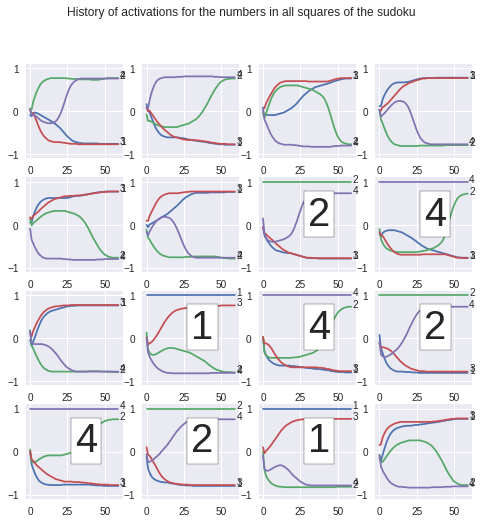

In [38]:
sudoku1.plot_activation_history()

### Observations:
- after initializing the activations randomly I see a lot of fluctuation in the final activation
- in almost all cases at least one incorrect number also ends up with high activation
- the correct number has a high activation more often than not

### Further ideas:
- ensemble ECHO, i.e. aggregate the activations of multiple runs with different initial activations


## Ensemble ECHO

In [0]:
def ensemble(sudoku, n=10):
    final_activations = []
    for i in range(n):
        sudoku_task = ECHO(sudoku, threshold=.01)
        finished = False
        while not finished:
            finished = sudoku_task.activation_update()
        final_activations.append(sudoku_task.return_activations())
    return(sum(final_activations)/n)

def plot_final_activation(final_activation, n):
    size = len(final_activation[0])
    zero2size = list(range(size))
    positions = itertools.product(zero2size, zero2size)

    fig = plt.figure(figsize=((size**3)/8,(size**3)/8))
    fig.suptitle("Final average activations after n = {} runs".format(n))
    ncols = nrows = len(final_activation[0])

    for n, ij in enumerate(positions):
        i,j = ij
        plt.subplot(nrows, ncols, n+1)
        for k in range(size):
            history = final_activation[i,j,k]
            plt.scatter(10, history)
            plt.text(10+k/2+1, history, "{}".format(k+1))
            if history == 1:
                plt.text(5,-.5, "{}".format(k+1), fontsize=60, bbox=dict(facecolor="white"))
        plt.ylim((-1.1,1.1))
        plt.xlim((0,20))


Convergence reached. Convergence reached. Convergence reached. Convergence reached. Convergence reached. Convergence reached. Convergence reached. Convergence reached. Convergence reached. Convergence reached. Convergence reached. Convergence reached. Convergence reached. Convergence reached. Convergence reached. Convergence reached. Convergence reached. Convergence reached. Convergence reached. Convergence reached. Convergence reached. Convergence reached. Convergence reached. Convergence reached. Convergence reached. Convergence reached. Convergence reached. Convergence reached. Convergence reached. Convergence reached. Convergence reached. Convergence reached. Convergence reached. Convergence reached. Convergence reached. Convergence reached. Convergence reached. Convergence reached. Convergence reached. Convergence reached. Convergence reached. Convergence reached. Convergence reached. Convergence reached. Convergence reached. Convergence reached. Convergence reached. Convergence r

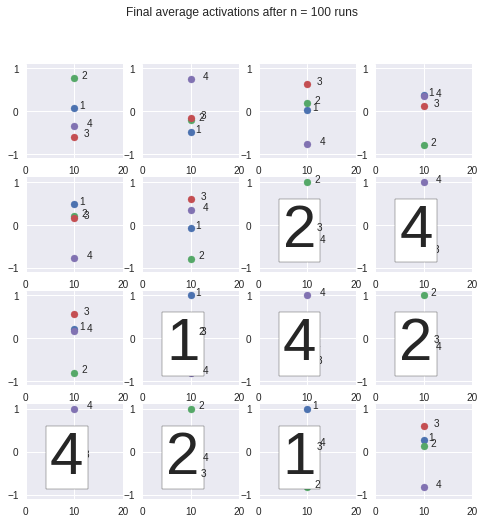

In [47]:
n = 100
final_activation = ensemble(example4x4, n=n)
plot_final_activation(final_activation, n)

### Observations
- the ensemble of 10 runs always gave the correct number the highest activation
- does this work with more difficult 4x4 Sudokus?
 - yes, even missing half of the numbers it gets it right
- how about 9x9 Sudokus?
 - also works well, I'm a bit impressed

## Some checks

In [49]:
# weights seem to be correct
# the first of the four matrices represents the weights within the first row
# within the first matrix, the first vector are the weights within one square
# weights of the unit "There is a 2 in the second square of the second row"
sudoku1.weights[1,1,1]

array([[[ 0.        , -0.11111111,  0.        ,  0.        ],
        [ 0.        , -0.11111111,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ]],

       [[ 0.        , -0.11111111,  0.        ,  0.        ],
        [-0.11111111,  0.        , -0.11111111, -0.11111111],
        [ 0.        , -0.11111111,  0.        ,  0.        ],
        [ 0.        , -0.11111111,  0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        , -0.11111111,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        , -0.11111111,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ]]])